In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import os
from pathlib import Path
from tensorflow import keras
import time


from pandarallel import pandarallel
import multiprocessing as mp
import concurrent.futures
import pandas.util.testing as pdt


#Tools for balancing data
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from imblearn.over_sampling import SMOTE

#Tools for building neural networks
from keras.models import Sequential
from keras.layers import Conv2D

#Tools for processing the images
from skimage import color
from skimage.transform import resize
from skimage.filters import threshold_otsu
from skimage.filters import threshold_local
from skimage.filters import try_all_threshold

#Tools for preparing train, test, and validation sets
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from collections import Counter

#Seperate file containing custom functions
from my_functions import * 

/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

# Preprocessing the data

In this step, we will preprocess the data so as to make it usable for our models. Firstly we will import the data using the IQR csv that we created in the Data Loading and Visualisation notebook.

In [2]:
#Import the data
my_data = pd.read_csv('iqr_raw.csv')
print(my_data.shape)
my_data.head()

(32446, 5)


,Book ID,Unicode,Character,File,Count
0,100241706,U+865A,虚,./all/100241706/characters/U+865A/U+865A_10024...,1
1,100241706,U+865A,虚,./all/100241706/characters/U+865A/U+865A_10024...,1
2,100241706,U+865A,虚,./all/100241706/characters/U+865A/U+865A_10024...,1
3,100241706,U+865A,虚,./all/100241706/characters/U+865A/U+865A_10024...,1
4,100241706,U+3063,っ,./all/100241706/characters/U+3063/U+3063_10024...,1


We can see that the dataframe consists of 5 columns and 32,446 rows. 

In [3]:
#Group the classes by the amount of observations, showing us how many classes had x observations.
by_char = my_data.groupby(["Unicode"])["Count"].sum()

#Seperate the characters and counts into lists
unicodes = by_char.index.values.tolist()
total_observations = by_char.tolist()

#Create a new dataframe
unique_charIQR = pd.DataFrame()
unique_charIQR.insert(loc=0, column='Unicode', value=unicodes)

#Create a list to store the literal characters
character_literal = []

#Convert from unicode to literal characters
for i in range(0,len(unicodes)):
    uni = unicodes[i]
    character_literal.append(chr(int(uni[2:], 16)))
    
#Add the literal characters as a column to the data frame
unique_charIQR.insert(1, "Character", character_literal, True) 

#Add the counts of each character 
unique_charIQR.insert(2,"Count",total_observations)

#Save the new dataframe as a csv
unique_charIQR.to_csv('kuzushiji_grouped_by_character.csv', index=False) 

#Preview the new dataframe
unique_charIQR.head(10)


,Unicode,Character,Count
0,U+0031,1,2
1,U+0032,2,4
2,U+0039,9,3
3,U+2000B,𠀋,16
4,U+20D45,𠵅,10
5,U+22999,𢦙,4
6,U+241C6,𤇆,2
7,U+242CE,𤋎,2
8,U+24E30,𤸰,3
9,U+24FA3,𤾣,2


In [4]:
print("Total characters observations: ",sum(unique_charIQR['Count']))
print("Total Unique Character classes: ",unique_charIQR.shape[0])

Total characters observations:  32446
Total Unique Character classes:  2459



# Splitting the data into training and test groups

Now that we have imported the data, we can split our data into training as test groups. However as we are working with 2,459 unique classes, there is a chance that if we simply sample randomly, we could end up with a train and test set with two very different distributions in terms of class representation. We will therefore use stratified sampling to preserve the distribution of each class.

In [5]:
#Convert the unicode labels to integers so we can use them with our classifier
labels = my_data['Unicode']
labels = labels.values.tolist()
label_encoder = LabelEncoder()
Y = np.array(label_encoder.fit_transform(labels))
Y = np.array(labels)
Y


#Create a training and testing set
x_train, x_test, y_train, y_test = train_test_split(my_data['File'], Y,random_state=42,train_size=0.7,stratify=Y)


#Convert the pandas series to lists
#x_train = x_train.tolist()
#y_train = y_train.tolist()
#x_test = x_test.tolist()

#Examine the size of each set
print("The training set has "+ str(len(x_train))+" observations")
print("The test set has "+ str(len(x_test))+" observations")



The training set has 22712 observations
The test set has 9734 observations


At the moment, the training and testsets only contain lists of file names rather than the images themselves

In [7]:
print(x_train.values[0:5])

['./all/200021712/characters/U+96D1/U+96D1_200021712_00020_2_X1500_Y2426.jpg'
 './all/hnsd00000/characters/U+68C4/U+68C4_hnsd004_027_X0823_Y1598.jpg'
 './all/brsk00000/characters/U+7FA4/U+7FA4_brsk004_033_X1394_Y1824.jpg'
 './all/umgy00000/characters/U+43FB/U+43FB_umgy005_018_X0103_Y0945.jpg'
 './all/200004148/characters/U+559A/U+559A_200004148_00082_2_X0232_Y0536.jpg']


In the next step we will start working with the images themselves.

# Examining the Images and generating augmentations

The Kuzushiji data set consists of both full pages from the books, as well as images of the individual characters on each page. Here is a sample image of each.


Example image of a full page:


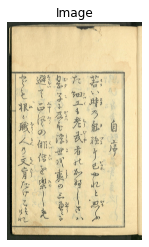


Example image of an individual character:


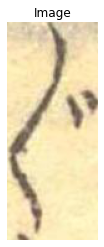

In [8]:
#Load a sample page image
file = Path("all/100241706/images/100241706_00004_2.jpg")
stem = file.stem

sample_page = plt.imread(file)
print("\nExample image of a full page:")
show_image(sample_page)

file = Path("all/100249476/characters/U+3032/U+3032_100249476_00020_1_X0285_Y0567.jpg")
stem = file.stem

sample_char = plt.imread(file)
print("\nExample image of an individual character:")
show_image(sample_char)

Although we are focusing on the interquartile range of the dataset in terms of character frequency, there is still alot of imbalance in the data set. In particular, a large proportion character classes have less than 10 observations

In [231]:
total_less_than(9,unique_charIQR)


Number of characters with 9 or fewer observations: 1367
This makes up: 55.589999999999996% of the classes


We can also see that after splitting our data into training and testing sets, the number of classes with less than 10 observations has increased.

In [232]:
x_traindf = pd.DataFrame()
x_traindf.insert(loc=0, column='Unicode', value=y_train)
x_traindf.insert(loc=1, column='Files', value = x_train.values)
x_traindf.head(5)

#Get an array with the Unicodes
characters = np.array(y_train)

#Group all characters by their Unicode this returns two numpy arrays representing the characters 
#and the count of each character in the dataframe

unique_char, counts = np.unique(characters, return_counts=True)

#Merge the two arrays into a dictionary
counted = dict(zip(unique_char, counts))

less_than_10_obs = {char:count for char, count in counted.items() if count < 10}
less_than_10_obs = list(less_than_10_obs.keys())

print("Number of unique characters in training set with less than 10 observations: ",len(less_than_10_obs))

#Create a new dataframe only consisting of characters classes with less than 10 observations
to_augment = x_traindf[x_traindf.Unicode.isin(less_than_10_obs)]
print("Total characters in training set that belong to classes with less than 10 observations: ",to_augment.shape[0]) 


Number of unique characters in training set with less than 10 observations:  1617
Total characters in training set that belong to classes with less than 10 observations:  6041


This will pose an issue when it comes to applying a balancing algorithm. Popular balancing algorithms like Random Oversampling, rely on randomly sampling from minority classes with replacement to generate extra samples for the minority classes. However, if a character only has one observation in the training set, then the algorithm will just sample the same image multiple times, resulting in an overfitted model.

Other algorithms like Synthetic Minority Oversampling Technique (SMOTE), generate synthetic examples by choosing an observation in a minority class and comparing it to it's nearest neighbours, with the synthetic observation being a point between the selected observation and it's neighbours. However, if a minority class doesn't have many observations, SMOTE won't be able to use an observation's neighbours to generate new samples.

In order to address this, we will use a technique called augmentation. By taking a sample image from minority classes (defined as classes with less than 10 observations in this case) and slightly augmenting the image in different ways adjusting things like it's brightness, it's position, and scale, and then storing the augmented image as a new observation.

We will use augmentation so that each class has at least 10 observations. We will then apply SMOTE afterwards to balance all of the classes. While it is common to sometimes augmente an image by flipping it horizontally or vertically, because we are working with a written language problem, we will not invert the image as it is assumed that the characters would always be written frontwise.

First we will select a random observation from each of the minority classes:

In [ ]:
#Randomly sample one observation per character class with less than 10 observations
N = 1
to_augment = to_augment.groupby('Unicode').apply(lambda x:x.sample(N)).reset_index(drop=True)
print("Number of sample images to be used for generating augmented data: ",to_augment.shape[0])

Now, we will get a list of the file paths for each random observation we sampled, it's label, and we will calculate the number of augmentations we will need to generate (so that the class has exactly 10 observations.

In [ ]:
#Get the file paths of the images to augment, their labels and the number of augmentations required.

to_augment_files = []
to_augment_label = []
number_of_augmentations = []

for i in to_augment['Unicode']:
    if(counted.get(i) < 10):
        to_augment_files.append(to_augment.loc[to_augment['Unicode'] == i, 'Files'].values[0])
        to_augment_label.append(i)
        number_of_augmentations.append(10-counted.get(i))

len(to_augment_files)

Now we will perform the actual augmentation. The main ways in which we will be manipulating the images will be by adjusting their brightness, shifting parts of the image vertically and horizontally, zooming in on certain parts of the images, and rotating the images slightly (no more than 10 degrees. 

In [ ]:
#Takes around 40 seconds

#Measure the processing time
start = time.perf_counter()

augmented_images = []
augmented_labels = []
for i in range(0,len(to_augment_files)):
    augmented_images.append(generate_data(to_augment_files[i],n=number_of_augmentations[i]))
    for k in range(0,number_of_augmentations[i]):
        augmented_labels.append(to_augment_label[i])

finish = time.perf_counter()
print(f'Finished generating images in {round(finish-start,2)} seconds')

Here is an example of the augmentations performed:

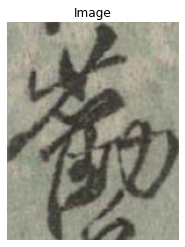

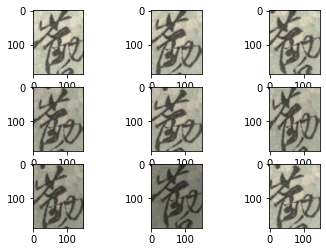

In [244]:
show_image(plt.imread(x_train.values[38]),"Original image")
example = generate_data(x_train.values[38],n=9,view='yes')


# Processing the images

Now that we have generated some augmented synthetic samples, we will load all of the remaining images in our training set using the file names we have stored and apply several transformations to them in order to use the images with our models. 

Specifically these transformations will involve three steps:

1. We resize each image so they are all the same size. The reason for this is because for image classifiers, each pixel represents an independent variable. Our models will require values for all of the variables to properly work. The larger the image size the better the quality, however a larger image size means that the computational time will also increase. Given that we are working with handwritten letters with distinct lines, we can compromise some of the quality in favour of improving computation time, becausea lot of the smaller details (smudges etc.) are not important in distinguishing the characters from each other. For this reason, we will set the size to 64 by 64 pixels. 


2. We will convert the images from RGB into grayscale. A standared RGB image is represented by three arrays of nxn elements. Where each array represents a colour (red, blue, and green), each element corresponds to a pixel, and the element's value represents the pixel intensity of the colour in the image. By converting to grayscale, we are reducing this to just one colour channel/one array.


3. Lastly, we will apply thresholding to make the images completely black and white. This works by setting a critical value, and assigning any pixel greater than this value to white, and any pixel less than it to black. This essentially creates a single array consisting of binary values and will make it easier for our models to process. It will also help address issues such as ink from characters on the opposite side of the page, smudges/shadows etc interfering with the model's calculations.


Below is an example of each of the transformations with a sample image.


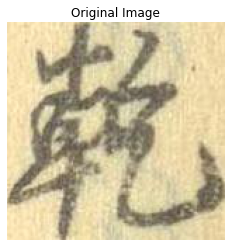

Original image dimensions:  (155, 155, 3)


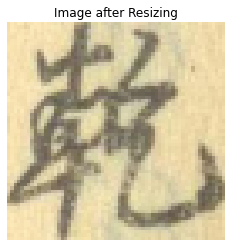

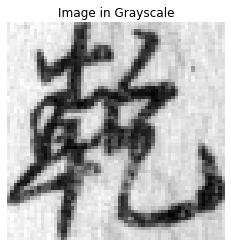

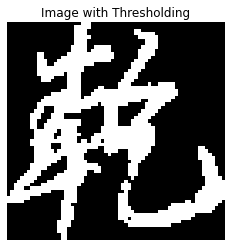

New image dimensions:  (65, 65)


In [9]:
#Original image
sample_char = plt.imread("all/100241706/characters/U+4E7E/U+4E7E_100241706_00029_1_X1774_Y1384.jpg")
show_image(sample_char,"Original Image")

print("Original image dimensions: ",sample_char.shape)

#Resize the image
img_size = 65
sample_char = resize(sample_char,(img_size,img_size))

show_image(sample_char,"Image after Resizing")

#Convert image to grayscale
sample_char = color.rgb2gray(sample_char)
show_image(sample_char,'Image in Grayscale')

#Apply thresholding to the image to make it Black and White
#Find the critical value
thresh_otsu = threshold_otsu(sample_char)
#Apply thresholding
sample_char = sample_char <= thresh_otsu 

show_image(sample_char, "Image with Thresholding")

print("New image dimensions: ",sample_char.shape)

## Processing the training dataset

We will now proceed to process all of the image files in our training data set by using the list of file names in our training set to load the images, and perform the transformations described abover. To speed up this process, we will use parallel processing. The details of the functions used are included in a seperate file called 'My_functions.py'.

This will return a list of numpy arrays which correspond to the processed images.

In [245]:
#Custom method with Multiprocessing to process the images
#Takes around 25 seconds and produces a list of arrays which match the Y labels and file lists

#Measure the processing time
start = time.perf_counter()

#Use parallelization to apply image processing to the training set
x_train_processed = parallelize_process(x_train.values)

finish = time.perf_counter()
print(f'Finished image processing in {round(finish-start,2)} seconds')


  0%|          | 0/22712 [00:00<?, ?it/s]

Starting the image processing with 16 processing units.


100%|██████████| 22712/22712 [00:19<00:00, 1173.25it/s]


Closing the pool...
Joining the pool...
Finished image processing in 25.66 seconds


To check that the images have been processed correctly, let's preview the first 5 characters of the training set.

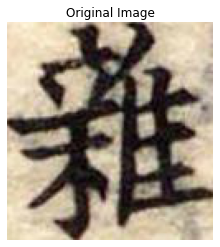

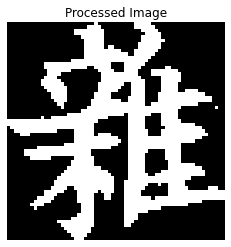

The label for image 0:  雑
The Unicode: U+96D1
The filepath:./all/200021712/characters/U+96D1/U+96D1_200021712_00020_2_X1500_Y2426.jpg


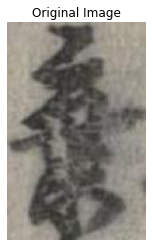

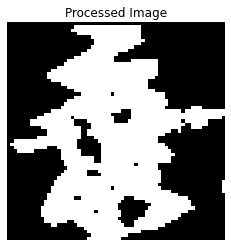

The label for image 1:  棄
The Unicode: U+68C4
The filepath:./all/hnsd00000/characters/U+68C4/U+68C4_hnsd004_027_X0823_Y1598.jpg


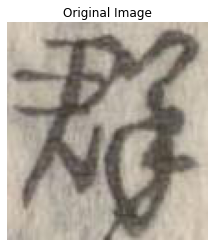

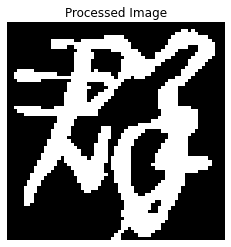

The label for image 2:  群
The Unicode: U+7FA4
The filepath:./all/brsk00000/characters/U+7FA4/U+7FA4_brsk004_033_X1394_Y1824.jpg


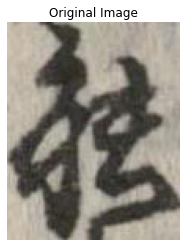

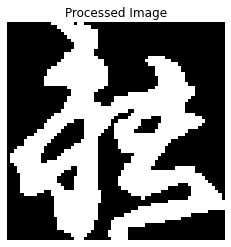

The label for image 3:  䏻
The Unicode: U+43FB
The filepath:./all/umgy00000/characters/U+43FB/U+43FB_umgy005_018_X0103_Y0945.jpg


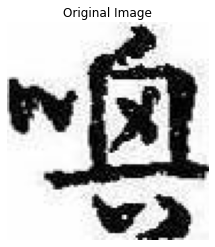

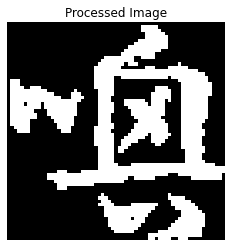

The label for image 4:  喚
The Unicode: U+559A
The filepath:./all/200004148/characters/U+559A/U+559A_200004148_00082_2_X0232_Y0536.jpg


Total Length of original list of file names:  22712
Total Length of list of processed images:  22712


In [27]:
#Preview the images
for i in range(0,5):
    show_image(plt.imread(x_train.values[i]),"Original Image")
    show_image(x_train_processed[i],"Processed Image")
    unicode = y_train[i]
    print(f"The image's character literal {i}: ",chr(int(unicode[2:], 16)))
    print(f"The Unicode: {y_train[i]}")
    print(f"The filepath:{x_train.values[i]}")

print("\n\nTotal Length of original list of file names: ",len(x_train))
print("Total Length of list of processed images: ",len(x_train_processed))

We can see that overall, the lines and shapes of the characters has been preserved after processing them. While the second transformed image is not particularly well defined, we can also see that the original image is rather poor quality as well, so transforming the images does not seem to have resulted in data loss.

# Processing the Augmented images


We will now process the augmented images that we generated as well and add them to the training data set. We have also stored their corresponding labels and will add them to the y_train set appropriately.

In [246]:
#Process the Augmented Images
#Takes around 25 seconds

#Measure the processing time
start = time.perf_counter()

processed_augmentations = []
for i in range(0,len(augmented_images)):
    for k in range(0,number_of_augmentations[i]):
        processed_augmentations.append(process_images(augmented_images[i][k]))
        
finish = time.perf_counter()
print(f'Finished processing images in {round(finish-start,2)} seconds')

Finished processing images in 27.66 seconds


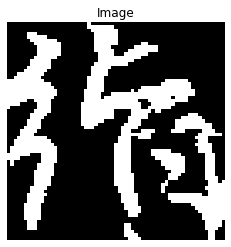

Label:  U+25FFB
The image's character literal:  𥿻


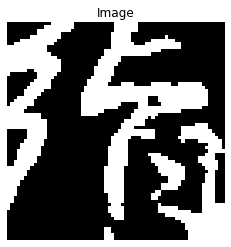

Label:  U+25FFB
The image's character literal:  𥿻


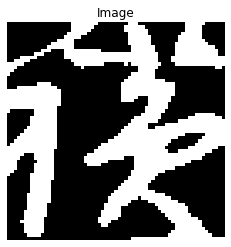

Label:  U+27752
The image's character literal:  𧝒


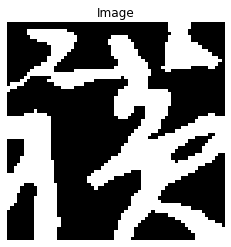

Label:  U+27752
The image's character literal:  𧝒


In [253]:
for i in range(98,102):
    show_image(processed_augmentations[i])
    print("Label: ",augmented_labels[i])
    print(f"The image's character literal: ",chr(int(augmented_labels[i][2:], 16)))


In [ ]:
#Add the augmented characters and their labels to the training set
y_train = list(y_train)
y_train = y_train + augmented_labels
y_train = np.array(y_train)
x_train_processed = x_train_processed + processed_augmentations

# Balancing the Training set

Now that we have generated augmented samples and processed the images appropriately, we will apply the Synthetic Minority Oversampling Technique (SMOTE) algorithm to balance the classes in our training data.

In [308]:
smote = SMOTE(random_state=42)

x_train_processed = np.array(x_train_processed)
n = x_train_processed.shape[0]
d2 = x_train_processed.shape[1]

x_train_processed = x_train_processed.reshape((n,d2*d2))

x_train_processed = x_train_processed1.astype(int)


Before applying SMOTE, if we preview the amount of observations per character class, we can see that the numbers of observations are still different (however there are no longer any classes with less than 10 observations).

In [327]:
characters = np.array(y_train)

unique_char, counts = np.unique(characters, return_counts=True)

#Merge the two arrays into a dictionary
counted = dict(zip(unique_char, counts))

dict(list(counted.items())[0:20])

{'U+0031': 10,
 'U+0032': 10,
 'U+0039': 10,
 'U+2000B': 11,
 'U+20D45': 10,
 'U+22999': 10,
 'U+241C6': 10,
 'U+242CE': 10,
 'U+24E30': 10,
 'U+24FA3': 10,
 'U+2564A': 10,
 'U+25877': 10,
 'U+25A0': 11,
 'U+25B3': 34,
 'U+25E2E': 10,
 'U+25FFB': 10,
 'U+27752': 10,
 'U+28263': 10,
 'U+3002': 10,
 'U+3006': 24}

In [ ]:
#Apply the SMOTE algorithm and balance the training data set
#Takes around 25 seconds

#Measure the processing time
start = time.perf_counter()

x_smote, y_smote = smote.fit_sample(x_train_processed1,y_train)

finish = time.perf_counter()
print(f'Finished...smoting?? in {round(finish-start,2)} seconds')

After Applying SMOTE, we can now see that all of the character classes have the same number of observations

In [329]:
characters = np.array(y_smote)

unique_char, counts = np.unique(characters, return_counts=True)

#Merge the two arrays into a dictionary
counted = dict(zip(unique_char, counts))

dict(list(counted.items())[0:20])

{'U+0031': 37,
 'U+0032': 37,
 'U+0039': 37,
 'U+2000B': 37,
 'U+20D45': 37,
 'U+22999': 37,
 'U+241C6': 37,
 'U+242CE': 37,
 'U+24E30': 37,
 'U+24FA3': 37,
 'U+2564A': 37,
 'U+25877': 37,
 'U+25A0': 37,
 'U+25B3': 37,
 'U+25E2E': 37,
 'U+25FFB': 37,
 'U+27752': 37,
 'U+28263': 37,
 'U+3002': 37,
 'U+3006': 37}

In [61]:
oversample = RandomOverSampler()
start = time.perf_counter()
x_over, y_over = oversample.fit_resample(x_train_processed_2_2d, y_train)
finish = time.perf_counter()
print(f'Finished balancing in {round(finish-start,2)} seconds')

MemoryError: Unable to allocate 402. GiB for an array with shape (102265890, 4225) and data type bool

In [133]:
x_train = np.expand_dims(x_train, -1)

oversample = RandomOverSampler()
x_over, y_over = oversample.fit_resample(x_train, y_train)

ValueError: Found array with dim 3. Estimator expected <= 2.

In [189]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[65,65]))
model.add(keras.layers.Dense(300,activation="relu"))
model.add(keras.layers.Dense(100,activation="relu"))
model.add(keras.layers.Dense(4328,activation="softmax"))


model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [190]:
x_val, y_val = np.array(x_val), np.array(y_val)

In [ ]:
model.fit(x_over,y_over,epochs=30, validation_data=(x_val,y_val))

Epoch 1/30
501/501 [==============================] - 70s 139ms/step - loss: 4.1932 - accuracy: 0.2561 - val_loss: 3.5164 - val_accuracy: 0.3051
Epoch 2/30
501/501 [==============================] - 69s 137ms/step - loss: 1.0052 - accuracy: 0.7847 - val_loss: 2.2798 - val_accuracy: 0.5294
Epoch 3/30
501/501 [==============================] - 66s 132ms/step - loss: 0.5426 - accuracy: 0.8769 - val_loss: 1.8312 - val_accuracy: 0.6176
Epoch 4/30
501/501 [==============================] - 59s 117ms/step - loss: 0.3869 - accuracy: 0.9071 - val_loss: 1.6678 - val_accuracy: 0.6213
Epoch 5/30
501/501 [==============================] - 51s 102ms/step - loss: 0.3359 - accuracy: 0.9171 - val_loss: 1.3629 - val_accuracy: 0.6949
Epoch 6/30
501/501 [==============================] - 48s 97ms/step - loss: 0.3036 - accuracy: 0.9254 - val_loss: 0.9175 - val_accuracy: 0.7500
Epoch 7/30
501/501 [==============================] - 48s 96ms/step - loss: 0.2432 - accuracy: 0.9380 - val_loss: 1.6640 - val_accu